In [1]:
# Settings
filename    = '/home/axel/PycharmProjects/pax/tpc_kr_150410_8k.hdf5'
#filename    = '/home/axel/PycharmProjects/pax/Kr83m_tpc_gaseous_lutz_150522_coin1_th300_6.hdf5'
file_format = 'hfd5'
loglevel    = 'DEBUG'

In [2]:
# Import modules
# We get a log file
import logging
log = logging.getLogger('XAMS_analysis')
log.setLevel(loglevel)
# Notebookloader is needed to import ipython notebooks as python modules.
# Notebookloader prompts a warning, but it seems to work fine
# TODO Perhaps we need to reconsider what functions we actually need and put them in a regular python script?
import NotebookLoader
import Function_definitions as fn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font', size=16)
import h5py
import units
from recarray_tools import append_fields

# Optional progress bar
try:
    from tqdm import tqdm
except ImportError:
    log.debug("You don't have tqdm, I can't give you a nice progress bar...")
    def dummy(*args,**kwargs):
        return args[0]
    tqdm = dummy

importing IPython notebook from Function_definitions.ipynb


/home/axel/anaconda3-2.2/lib/python3.4/site-packages/IPython/nbformat/current.py:19: UserWarning: IPython.nbformat.current is deprecated.

- use IPython.nbformat for read/write/validate public API
- use IPython.nbformat.vX directly to composing notebooks of a particular version

  """)


In [3]:
##
# Load the data
##
log.debug("Now loading %s (file format=%s)..." % (filename, file_format))

# Slurp peaks and events into memory
# WARNING: For a large dataset, use pax to remove big low-level fields first
# (area_per_channel, does_channel_contribute, does_channel_have_noise)
import h5py
f = h5py.File(filename)
events = f.get('Event')[:]
peaks = f.get('Peak')[:]
f.close()

log.info("Loaded %s, containing %d peaks (%0.2f MB RAM) and %d events (%0.2f MB RAM)" % (
    filename, len(peaks), peaks.nbytes/10**6, len(events), events.nbytes/10**6))
if len(events) == 0:
    raise ValueError("You don't have any events in this dataset!")

DEBUG:XAMS_analysis:Now loading /home/axel/PycharmProjects/pax/tpc_kr_150410_8k.hdf5 (file format=hfd5)...
INFO:XAMS_analysis:Loaded /home/axel/PycharmProjects/pax/tpc_kr_150410_8k.hdf5, containing 2172121 peaks (764.59 MB RAM) and 488700 events (187.66 MB RAM)


In [4]:
# Append fields to the event and peak list. Only the ones that can be directly determined from the events lists

# full range: the total time of the peak.
peaks = append_fields(peaks, 'full_width', (peaks['right'] - peaks['left'] + 1)*fn.dt)
peaks = append_fields(peaks,'mid',peaks['left']*fn.dt + 0.5* peaks['full_width'])

# Recalculate area fraction top because of wrong ordering of PMTs
peaks['area_fraction_top'] = peaks['area_per_channel'][:,3] / peaks['area']

In [5]:
# Loop over peaks and redefine the classification
NaI_cut   = (peaks['detector'] == b'NaI')
s1_cut    = ((peaks['detector'] == b'tpc') & (peaks['area']/peaks['full_width'] > 0.020 ) &
             (peaks['area'] >10) & (peaks['area_fraction_top']<0.35) )
s2_cut    = ((peaks['detector'] == b'tpc') & (peaks['area']/peaks['full_width'] > 0.020 ) &
             (peaks['area'] >100) & (peaks['area_fraction_top']>0.35) & (peaks['full_width'] > 1.*units.us) )

peak_types  = ["s1","s2","NaI","other"]
reclassified = []

for i in range(len(s1_cut)):
    if(s1_cut[i]):
        reclassified.append("s1")
    elif(s2_cut[i]):
        reclassified.append("s2")
    elif(NaI_cut[i]):
        reclassified.append("NaI")
    else:
        reclassified.append("other")

peaks = append_fields(peaks,'true_type',reclassified)

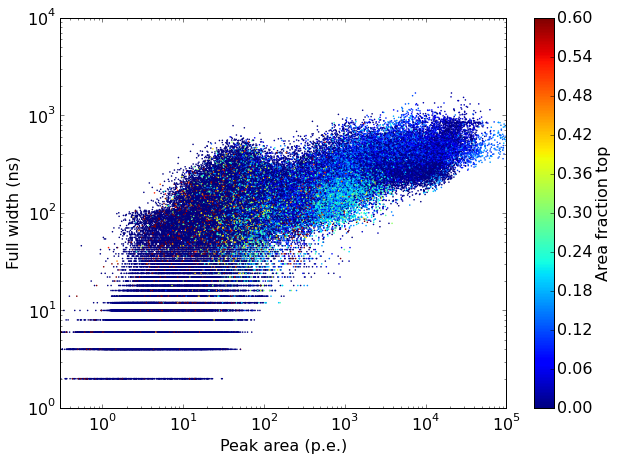

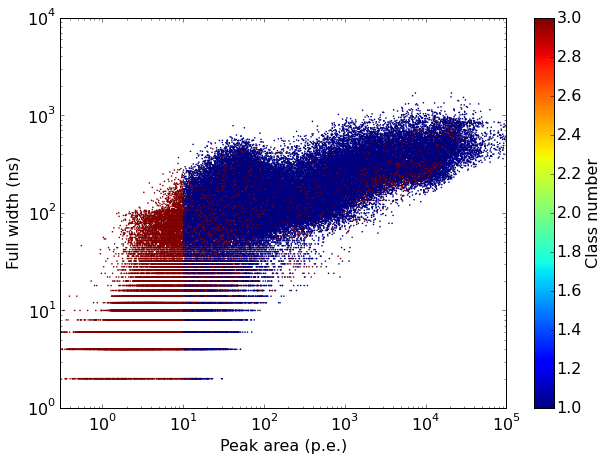

In [6]:
# Check the classification #
maxn = 100000
plt.figure(figsize=(10,7))
plt.scatter(peaks['area'][:maxn],
           peaks['full_width'][:maxn],
           c=peaks['area_fraction_top'][:maxn],
           marker='.', edgecolor='None', alpha=1, s=10,
           vmax=0.6)
           # gridsize = 100,bins='log',
          #xscale='log', yscale='log')
plt.yscale('log')
plt.xscale('log')
plt.xlim(3*10**(-1),10**(5))
#plt.ylim(3*10**(0),10**(5))
plt.xlabel('Peak area (p.e.)')
plt.ylabel('Full width (ns)')
plt.colorbar(label="Area fraction top",)
plt.show()


maxn = 100000
classnumber = []
for i in range(maxn):
    if (peaks['true_type'][i] =='s1'):
        classnumber.append(1)
    if (peaks['true_type'][i] =='s2'):
        classnumber.append(2)
    if (peaks['true_type'][i] =='other'):
        classnumber.append(3)
    if (peaks['true_type'][i] =='NaI'):
        classnumber.append(0)
plt.figure(figsize=(10,7))
plt.scatter(peaks['area'][:maxn],
           peaks['full_width'][:maxn],
           c=classnumber,
           marker='.', edgecolor='None', alpha=1, s=10,
           )
           # gridsize = 100,bins='log',
          #xscale='log', yscale='log')
plt.yscale('log')
plt.xscale('log')
plt.xlim(3*10**(-1),10**(5))
#plt.ylim(3*10**(0),10**(5))
plt.xlabel('Peak area (p.e.)')
plt.ylabel('Full width (ns)')
plt.colorbar(label="Class number",)
plt.show()

In [7]:
# Group peaks by event
peaks_per_event = fn.group_by(peaks, 'Event')
#assert len(peaks_per_event) == len(events) # Raise error if false

# Add total number of peaks
#events = append_fields(events,
#                       'n_peaks',
#                       np.array([len(x) for x in peaks_per_event]))

# Add number of individual peak types


for pt in peak_types:
    events = append_fields(events,
                           'n_'+pt,
                           np.array([len(x[x['true_type'] == pt]) for x in peaks_per_event]))
# Add number of BIG peaks (mainly S2 is important). Use to cut pileup / double scatters    
    events = append_fields(events,
                           'n_big_'+pt,
                           np.array([len(x[(x['type'] == pt) & (x['area'] >= 100)]) for x in peaks_per_event]))

In [8]:
##
# Select events with >=1 S1 and >=1 S2
# Necessary step for next cell
##
n_before = len(events)
cut = (events['n_s1'] >= 1) & (events['n_s2'] >= 1)
events = events[cut]
peaks_per_event = [x for i, x in enumerate(peaks_per_event) if cut[i]]

log.debug("%0.2f%% of events have >=1 S1 and S2, keeping only those." % (100*len(events)/n_before))
if((100*len(events)/n_before)<50):
    log.warning("Only %0.2f%% of events have >=1 S1 and S2, keeping only those." % (100*len(events)/n_before))

DEBUG:XAMS_analysis:0.05% of events have >=1 S1 and S2, keeping only those.


In [9]:
##
# Add s1_... and s2_... fields to event
# This way you can access all properties of the main S1 and S2 directly from the event
# TODO add peak area per channel
##
ignore_fields = ['Event', 'Peak', 'type',
                 # recfunctions have trouble with subarrays...
                 'does_channel_contribute', 'does_channel_have_noise', 'area_per_channel']
for pt in ('s1', 's2'):
    main_peaks = []
    for pks in tqdm(peaks_per_event, desc='Selecting %ss' % pt):
        peaks_of_this_type =  pks[pks['true_type'] == pt]
        main_peaks.append(
            peaks_of_this_type[
                np.argmax(
                   peaks_of_this_type['area']
                )
            ])
    main_peaks = np.array(main_peaks)
    assert len(main_peaks) == len(peaks_per_event)

    # Add s1_... and s2_... fields
    for fn in main_peaks.dtype.names:
        if fn in ignore_fields:
            continue
        events = append_fields(events,
                               "%s_%s" % (pt, fn),
                               main_peaks[fn])
        
if(len(peaks[peaks['detector']==b'NaI']) > 0):
    log.debug('Found external NaI, will add those properties!')
    main_peaks = []
    for pks in tqdm(peaks_per_event, desc='Selecting NaI pulses'):
        peaks_of_this_type =  pks[pks['true_type'] == 'NaI']
        main_peaks.append(
            peaks_of_this_type[
                np.argmax(
                   peaks_of_this_type['area']
                )
            ])
    main_peaks = np.array(main_peaks)
    assert len(main_peaks) == len(peaks_per_event)

    # Add NaI_... fields
    for fn in main_peaks.dtype.names:
        if fn in ignore_fields:
            continue
        events = append_fields(events,
                               "NaI_%s" % fn ,
                               main_peaks[fn])
else:
   log.debug('No NaI found, so just TPC channels added.')

DEBUG:XAMS_analysis:No NaI found, so just TPC channels added.


In [10]:
# Add drift time
events = append_fields(events, 'drift_time', events['s2_hit_time_mean'] - events['s1_hit_time_mean'])
# Drift time is here from hit time mean to hit time mean. Its the mean of the hit maximum weighted by area.
# This DOES introduce a constant, but it's probably a very stable quantity.

In [11]:
################ Corrections ######################
import scipy.integrate
import math

#btw, the function of the LCE I got for the fit is:
#f_{LCE}(x) = (0.053 +/- 0.004) *x*x+ (1.866 +/- 0.208) *x + (258.3+/- 2.0)
def s1_correction_function(x):
    return 0.053 * x**2 +1.866*x +258.3

def get_average(s1_correction_function,maxtime):
    avg = scipy.integrate.quad(lambda x: s1_correction_function(x), 0, maxtime)[0] /maxtime
    return avg

events = append_fields(events, 's1_area_corr', 
                       events['s1_area']/s1_correction_function(events['drift_time']/units.us)*
                      get_average(s1_correction_function,60))

def s2_correction_function(x):
    return math.exp(-x/542.)

events = append_fields(events, 's2_area_corr', 
                       events['s2_area'])
for i in tqdm(range(len(events))):
    events['s2_area_corr'][i] = events['s2_area_corr'][i]/s2_correction_function(events['drift_time'][i]/units.us)

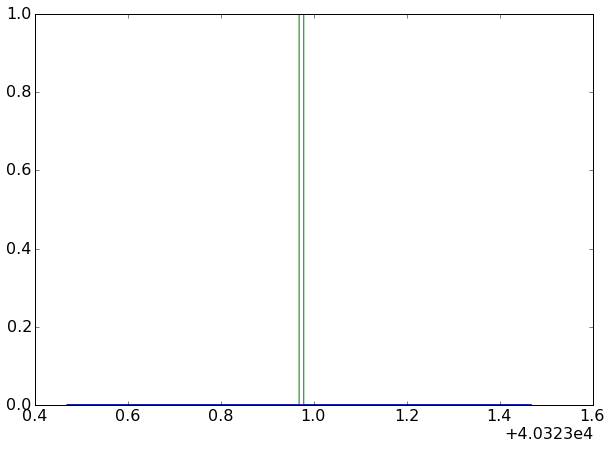

/home/axel/anaconda3-2.2/lib/python3.4/site-packages/matplotlib/axes/_axes.py:5684: RuntimeWarning: invalid value encountered in true_divide
  m = (m.astype(float) / db) / m.sum()


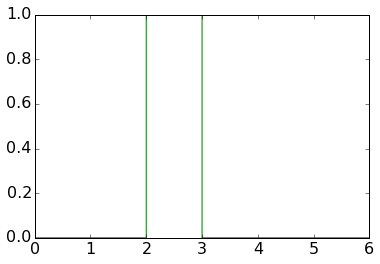

In [12]:
cut_negative = (events['drift_time'] < 0)
cut_normal   = (events['drift_time']>0) & (events['drift_time']<60*units.us)
cut_high     = (events['drift_time']>60*units.us)

plt.figure(figsize=(10,7))
plt.hist((events[cut_negative]['drift_time'],events[cut_normal]['drift_time'],events[cut_high]['drift_time'],),
         bins=100,histtype='step')
plt.show()

plt.hist((events[cut_negative]['n_s1']+events[cut_negative]['n_s2']-2,
          events[cut_normal]['n_s1']+events[cut_normal]['n_s2']-2,
          events[cut_high]['n_s1']+events[cut_high]['n_s2']-2),
        range=(0,6),bins=6,histtype='step',normed=True)
plt.show()

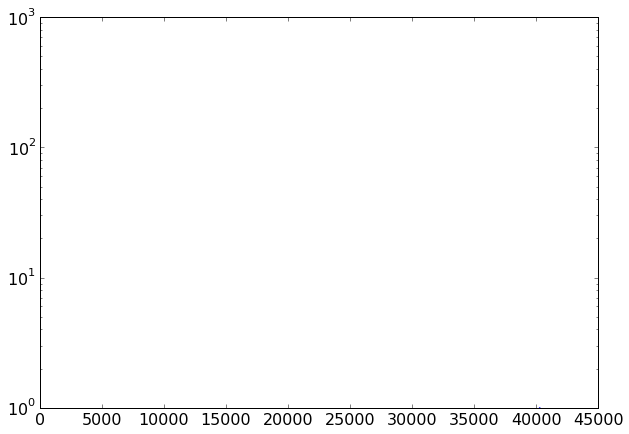

In [13]:
plt.figure(figsize=(10,7))
plt.hist(events['drift_time'],
         bins=1000,
         histtype='step')
plt.yscale("log")
plt.show()

In [14]:
?append_fields